In [1]:
import pandas as pd
import pickle
import os
import json
import re
from PIL import Image
import pprint
from scipy.stats import norm
prettyprint = pprint.PrettyPrinter(indent=4)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [3]:
import os
import locale
#locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

#from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
#BASE_DATA_PATH='../../data'
#BASE_IMAGES_PATH='../../images'
from covid19_pytoolbox import settings
settings.BASE_DATA_PATH='../../data'
settings.BASE_IMAGES_PATH='../../images'

from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.modeling.Rt import naive
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
IMGSUPMAT = 'italy/ABModelCOVID-19Diffusion_support_material'

In [5]:
alpha = 1.87
beta = 0.28

ALPHA=100.

In [6]:
cases_by_symptoms_onset_date = pd.read_csv(
    os.path.join(settings.BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2021-07-30T22:34:44+00:00.inizio_sintomi.csv')    
)

cases_by_symptoms_onset_date.loc[cases_by_symptoms_onset_date.CASI=='<5',['CASI']]=5
cases_by_symptoms_onset_date.CASI = cases_by_symptoms_onset_date.CASI.astype(int)
cases_by_symptoms_onset_date.dropna(inplace=True)

cases_by_symptoms_onset_date['data']= pd.to_datetime(
    cases_by_symptoms_onset_date.DATA_INIZIO_SINTOMI,
    format='%d/%m/%Y'
)

cases_by_symptoms_onset_date.sort_values(by='data', inplace=True)
cases_by_symptoms_onset_date.reset_index(drop=True, inplace=True)

In [7]:
cases_by_symptoms_onset_date

,iss_date,DATA_INIZIO_SINTOMI,CASI,data
0,30/07/2021,28/01/2020,16,2020-01-28
1,30/07/2021,29/01/2020,20,2020-01-29
2,30/07/2021,30/01/2020,26,2020-01-30
3,30/07/2021,31/01/2020,31,2020-01-31
4,30/07/2021,01/02/2020,51,2020-02-01
...,...,...,...,...
545,30/07/2021,26/07/2021,1317,2021-07-26
546,30/07/2021,27/07/2021,862,2021-07-27
547,30/07/2021,28/07/2021,419,2021-07-28
548,30/07/2021,29/07/2021,128,2021-07-29


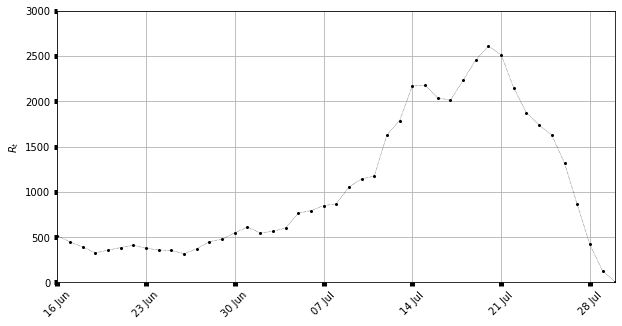

In [8]:
plotting.plot_series(
    figsize=(10,5),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,    
    data=[
        {
            'df':cases_by_symptoms_onset_date,
            'yfields': ['CASI'],
            'colors': ['black']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2021,6,16), datetime(2021,7,30)),#DPC_data.data.max()),
    ylim=(0,3000),
    legend_on=False,
    legend_loc="upper right"
)

In [9]:
cases_by_symptoms_onset_date["Rt_naive"] = naive.compute_Rt(cases_by_symptoms_onset_date.CASI, alpha, beta)

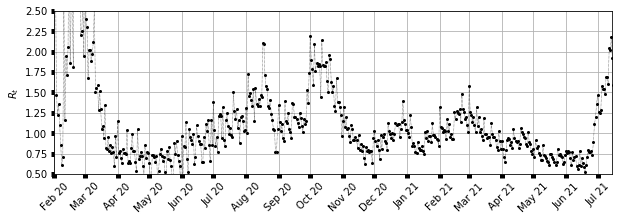

In [10]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date,
            'yfields': ['Rt_naive'],
            'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['black']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2020,2,1), datetime(2021,7,15)),#DPC_data.data.max()),
    ylim=(0.5,2.5),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset'),
    quality=40
)

In [11]:
cases_by_symptoms_onset_date['CASI_rolling_sum'] = cases_by_symptoms_onset_date.CASI.rolling(window=14).sum().fillna(0)

In [12]:
cases_by_symptoms_onset_date["Rt_naive_CASI_rolling_sum"] = naive.compute_Rt(cases_by_symptoms_onset_date.CASI_rolling_sum, alpha, beta)

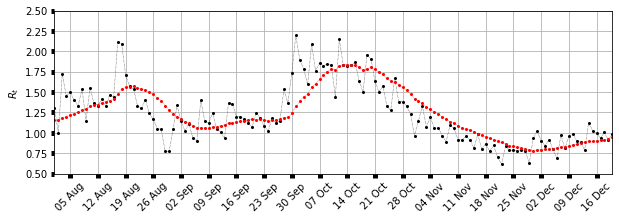

In [13]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date,
            'yfields': ['Rt_naive', 'Rt_naive_CASI_rolling_sum'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['black', 'red']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2020,8,1), datetime(2020,12,20)),#DPC_data.data.max()),
    ylim=(0.5,2.5),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset_window_14'),
    quality=40
)

In [14]:
def compute_offset(s_preceeding, s_following, start = -20, interval = 10):
    crosscorrs =[]
    for shift in range(start, interval):
        crosscorrs.append(
            s_preceeding.corr(s_following.shift(shift))
        )

    return start + crosscorrs.index(max(crosscorrs)), crosscorrs

In [15]:
compute_offset(cases_by_symptoms_onset_date.Rt_naive, cases_by_symptoms_onset_date.Rt_naive_CASI_rolling_sum)

(-13,
 [0.4747350760376214,
  0.4817287231813364,
  0.49206712165651206,
  0.5294313886048073,
  0.5671462908166671,
  0.6438669728364638,
  0.769979976619164,
  0.911913934933203,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan])

In [16]:
help(RSVD_smooth_data_generic)

Help on function RSVD_smooth_data_generic in module covid19_pytoolbox.utils:

RSVD_smooth_data_generic(df, filter_columns, alpha, beta, season_period=7, trend_alpha=100.0, difference_degree=2)



In [17]:
regularizer = TikhonovRegularization(timesteps=len(cases_by_symptoms_onset_date), alpha=100)

cases_by_symptoms_onset_date['CASI_smoothed'] = regularizer.stat_smooth_data(cases_by_symptoms_onset_date.CASI)

TIC R2: 0.9856045519661015


In [18]:
cases_by_symptoms_onset_date["Rt_naive_smoothed"] = naive.compute_Rt(cases_by_symptoms_onset_date.CASI_smoothed, alpha, beta)

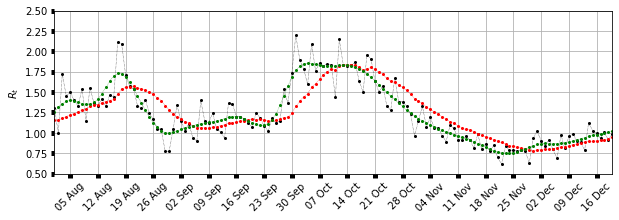

In [19]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date,
            'yfields': ['Rt_naive', 'Rt_naive_CASI_rolling_sum', 'Rt_naive_smoothed'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['black', 'red', 'green']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2020,8,1), datetime(2020,12,20)),#DPC_data.data.max()),
    #xlim=(datetime(2020,2,1), datetime(2021,7,15)),#DPC_data.data.max()),
    ylim=(0.5,2.5),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset_smoothed'),
    quality=40
)

In [20]:
compute_offset(cases_by_symptoms_onset_date.Rt_naive, cases_by_symptoms_onset_date.Rt_naive_smoothed)

(0,
 [0.43371107961498623,
  0.4335776827941269,
  0.4271471939163064,
  0.41822376408612266,
  0.4055619783622717,
  0.3922179666906857,
  0.37902176643210933,
  0.3662721853907274,
  0.3549579978118645,
  0.34764997386118385,
  0.3471124273347088,
  0.355796481398002,
  0.37503138092311716,
  0.4042949206420537,
  0.44294102956677517,
  0.4910288561727667,
  0.5498283405135765,
  0.6222561426523631,
  0.7150324681414032,
  0.8399872498781517,
  0.9618269553250363,
  0.8980923406283297,
  0.8156275785856776,
  0.7867060796061836,
  0.6170912513572336,
  0.49897146452507046,
  0.46153406711774697,
  0.4404882380590027,
  0.39975898107928187,
  0.36727143902688697])

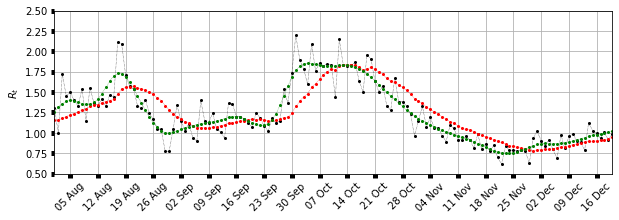

In [21]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date,
            'yfields': ['Rt_naive', 'Rt_naive_CASI_rolling_sum', 'Rt_naive_smoothed'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['black', 'red', 'green']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2020,8,1), datetime(2020,12,20)),#DPC_data.data.max()),
    #xlim=(datetime(2020,2,1), datetime(2021,7,15)),#DPC_data.data.max()),
    ylim=(0.5,2.5),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset_smoothed'),
    quality=40
)

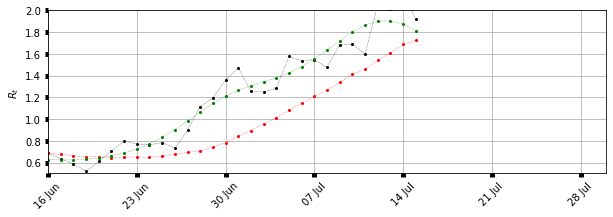

In [22]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date[cases_by_symptoms_onset_date.data<='2021-07-15'],
            'yfields': ['Rt_naive', 'Rt_naive_CASI_rolling_sum', 'Rt_naive_smoothed'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['black', 'red', 'green']
        }
    ],
    y_label='$R_t$',
    xlim=(datetime(2021,6,16), datetime(2021,7,30)),#DPC_data.data.max()),
    #xlim=(datetime(2020,2,1), datetime(2021,7,15)),#DPC_data.data.max()),
    ylim=(0.5,2),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFoarmatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset_smoothed_zoom'),
    quality=40
)

In [23]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999974300045711
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999965360004762
deceduti_giornalieri_smoothed - TIC R2: 0.9999981643842553
nuovi_positivi_smoothed - TIC R2: 0.9999983590624241
nuovi_casi_da_sospetto_diagnostico_smoot

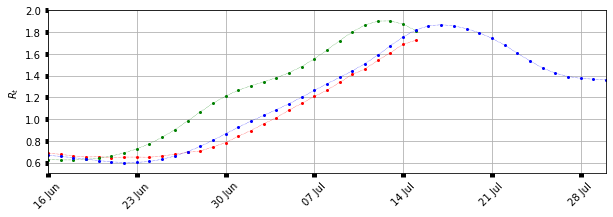

In [24]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[
        {
            'df':cases_by_symptoms_onset_date[cases_by_symptoms_onset_date.data<='2021-07-15'],
            'yfields': ['Rt_naive_CASI_rolling_sum', 'Rt_naive_smoothed'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['red', 'green']
        },
        {
            'df':DPC_data,
            'yfields': ['nuovi_positivi_smoothed_Rt'],
            #'labels': ['naive $R_t$ calculated on raw infected cases by symptoms onset date, official ISS dataset'],
            'colors': ['blue']
        }
        
    ],
    y_label='$R_t$',
    xlim=(datetime(2021,6,16), datetime(2021,7,30)),#DPC_data.data.max()),
    #xlim=(datetime(2020,2,1), datetime(2021,7,15)),#DPC_data.data.max()),
    ylim=(0.5,2),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFoarmatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'naive_Rt_symptoms_onset_vs_notification'),
    quality=40
)

In [25]:
cases_by_symptoms_onset_date['Rt_naive_smoothed_notification'] = DPC_data.nuovi_positivi_smoothed_Rt

In [26]:
cases_by_symptoms_onset_date = cases_by_symptoms_onset_date.merge(DPC_data[['data','nuovi_positivi_smoothed_Rt']], on=['data'])

In [27]:
compute_offset(cases_by_symptoms_onset_date.Rt_naive_smoothed, cases_by_symptoms_onset_date.nuovi_positivi_smoothed_Rt, start=-20, interval=20)

(-8,
 [0.6467324882866385,
  0.6917029936132612,
  0.733797357177415,
  0.7727451803654449,
  0.8085007597404312,
  0.8411615889619379,
  0.8708478124433957,
  0.8975696805833826,
  0.9211813399989919,
  0.9413721922158801,
  0.9576531342523183,
  0.9693120589963282,
  0.975292368464494,
  0.973900599333316,
  0.9622736237463885,
  0.9357201128998129,
  0.8870098540580167,
  0.8065962746820798,
  0.6843220413631953,
  0.5058159902474494,
  0.47270578128900137,
  0.4593308563130244,
  0.4446978901320668,
  0.4286025330466609,
  0.4110017168818988,
  0.39228934488972683,
  0.37323100423952427,
  0.3548727360851332,
  0.3375429525895085,
  0.3206721375689051,
  0.30299777828324226,
  0.28323075435139766,
  0.2604985334019802,
  0.23460153457272961,
  0.20612320559045585,
  0.1762849384836635,
  0.14653686451605,
  0.11791318856135953,
  0.09105122523524933,
  0.06632645164139432])

In [28]:
compute_offset(cases_by_symptoms_onset_date.nuovi_positivi_smoothed_Rt, cases_by_symptoms_onset_date.Rt_naive_CASI_rolling_sum, start=-20, interval=20)

(6,
 [0.20605465027679715,
  0.23148840064683676,
  0.2580261465419797,
  0.285201279554146,
  0.31004382642495204,
  0.3347835511861651,
  0.36330720173899905,
  0.37408399532849884,
  0.3860778524163985,
  0.3998817513726394,
  0.4165037452236069,
  0.4317568472189424,
  0.44922239375567197,
  0.47420420306611744,
  0.491821338834825,
  0.5103674916775516,
  0.4915770280826361,
  0.500186830551502,
  0.5015913059308008,
  0.5072424018024476,
  0.5201099450836346,
  0.5330158747563283,
  0.72004561275458,
  0.8366662209531383,
  0.9021813932770015,
  0.9313872091007287,
  0.9372903933111224,
  0.9291422471111792,
  0.9125600865666684,
  0.8906217370567912,
  0.8648132122655406,
  0.8358126894083897,
  0.8039885225905579,
  0.7696163536650602,
  0.7328951995069595,
  0.6939899236151555,
  0.6529858518334456,
  0.6100227096349855,
  0.5654570235203998,
  0.5198053024466646])

In [29]:
DPC_data['nuovi_positivi_residuals'] = (
    DPC_data.nuovi_positivi - DPC_data.nuovi_positivi_smoothed
)
DPC_data['nuovi_positivi_relative_residuals'] = (
    DPC_data.nuovi_positivi_residuals / DPC_data.nuovi_positivi_smoothed
)
DPC_data.loc[0,'nuovi_positivi_relative_residuals'] = 0

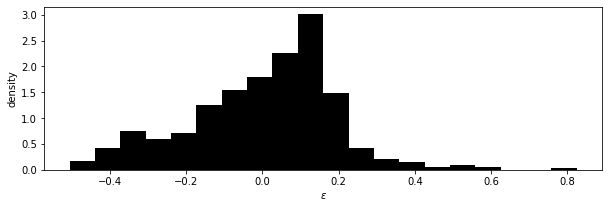

In [30]:
img_file_path_without_extension = \
    os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'epsilon_tikhonov_distribution')

fig, ax = plt.subplots(figsize=(10,3))

# the histogram of the data
_ = ax.hist(DPC_data.nuovi_positivi_relative_residuals, bins=20, color='black', density=True)

_ = ax.set_xlabel('$\epsilon$')
_ = ax.set_ylabel('density')

png_path = "{}.png".format(img_file_path_without_extension)
jpg_path = "{}.jpg".format(img_file_path_without_extension)

plt.savefig(png_path, dpi=150, pad_inches = 0.1, bbox_inches = 'tight')
im = Image.open(png_path)
rgb_im = im.convert("RGB")
rgb_im.save(jpg_path, optimize=True, quality=40)


In [31]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

[   'nuovi_positivi',
    'tamponi_giornalieri',
    'nuovi_ospedalizzati',
    'deceduti_giornalieri',
    'ingressi_terapia_intensiva']
nuovi_positivi_deseason
info_cri:  -2.1322004263018672
info_cri:  -1.7556693434524882
TIC R2: 0.9929608970626235
patterns: 1
(   -6.443603287432319,
    1.5857887008127952e-08,
    19,
    503,
    {   '1%': -3.4434175660489905,
        '10%': -2.5698395516760275,
        '5%': -2.8673031724657454},
    -306.121144779976)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.806777126270277
info_cri:  -0.5048469506605822
TIC R2: 0.9652333016573865
patterns: 1
(   -8.302576549441502,
    3.9816663509213675e-13,
    18,
    504,
    {   '1%': -3.443391504492468,
        '10%': -2.5698334393109095,

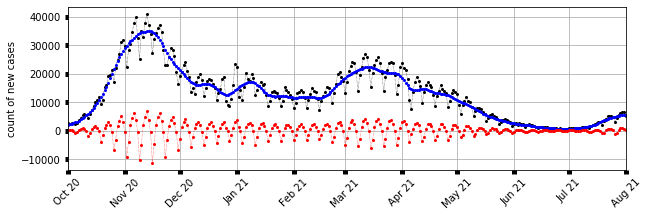

In [32]:
plotting.plot_series(
    figsize=(10,3),
    title_fontsize=10,
    label_fontsize=10,
    tick_fontsize=10,
    tick_width=5,
    message_fontsize=10,    
    legend_fontsize=10,
    markersize=2,
    linewidth=0.5,        
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ],
        'colors':['black', 'blue', 'red']
    }],
    y_label='count of new cases',
    #xlim=(datetime(2021,6,16), datetime(2021,7,30)),#DPC_data.data.max()),
    xlim=(datetime(2020,10,1), DPC_data.data.max()),
    #ylim=(0.5,2),
    #xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_on=False,
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'new_cases_deseason'),
    quality=40
)





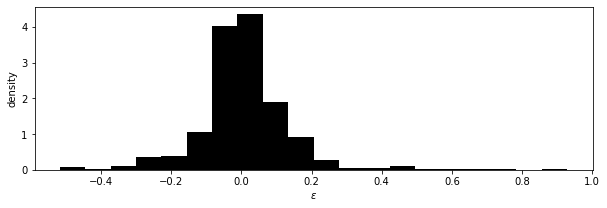

In [33]:
img_file_path_without_extension = \
    os.path.join(settings.BASE_IMAGES_PATH, IMGSUPMAT, 'epsilon_RSVD_distribution')

fig, ax = plt.subplots(figsize=(10,3))

# the histogram of the data
_ = ax.hist(DPC_data.nuovi_positivi_deseason_relative_residuals, bins=20, color='black', density=True)

_ = ax.set_xlabel('$\epsilon$')
_ = ax.set_ylabel('density')

png_path = "{}.png".format(img_file_path_without_extension)
jpg_path = "{}.jpg".format(img_file_path_without_extension)

plt.savefig(png_path, dpi=150, pad_inches = 0.1, bbox_inches = 'tight')
im = Image.open(png_path)
rgb_im = im.convert("RGB")
rgb_im.save(jpg_path, optimize=True, quality=40)
